<a href="https://colab.research.google.com/github/vKrRv/porta-trucks-detector/blob/plate-reader/ocr_license_plate_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Porta 🚛
### License Plates Reader

## Setup

In [ ]:
# Install dependencies
!pip install langchain langchain-community paddlepaddle paddleocr opencv-python-headless

In [ ]:
!pip install easyocr opencv-python-headless

In [3]:
# Import Libraries
import cv2
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import os

In [4]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [5]:
# Map each English letter/digit to its corresponding Arabic letter/digit for Saudi license plates
SAUDI_MAPPING = {
    'A': 'ا', 'B': 'ب', 'J': 'ح', 'D': 'د', 'R': 'ر', 'S': 'س',
    'X': 'ص', 'T': 'ط', 'E': 'ع', 'G': 'ق', 'K': 'ك', 'L': 'ل',
    'Z': 'م', 'N': 'ن', 'H': 'ه', 'U': 'و', 'V': 'ى'
}
DIGIT_MAPPING = {
    '0': '٠', '1': '١', '2': '٢', '3': '٣', '4': '٤',
    '5': '٥', '6': '٦', '7': '٧', '8': '٨', '9': '٩'
}

## Define Logic

In [7]:
# Augmenting the input image
def enhance_image(img):
    scale = 2
    img_large = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img_large, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

In [26]:
# Main function to read the plate
def process_plate_clean(image_path):

    if not os.path.exists(image_path):
        return {"error": "File not found"}, None, None, None

    original = cv2.imread(image_path)
    if original is None: return {"error": "Image corrupted"}, None, None, None

    h, w, _ = original.shape

    # 1. CUT HORIZONTAL: Keep Bottom 55%
    bottom_half = original[int(h * 0.45):, :]
    bh, bw, _ = bottom_half.shape
    mid_x = int(bw / 2) - int(bw * 0.02)
    gap = int(bw * 0.03)

    # 2. CUT VERTICAL (Left=Numbers, Right=Letters)
    start_nums = int(bw * 0.02)
    end_nums = mid_x - int(gap/2)
    crop_numbers = bottom_half[:, start_nums:end_nums]

    start_lets = mid_x + int(gap/2)
    end_lets = bw - int(bw * 0.02)
    crop_letters = bottom_half[:, start_lets:end_lets]

    # 3. Augment the images to for processing
    clean_L_Numbers = enhance_image(crop_numbers)
    clean_R_Letters = enhance_image(crop_letters)

    # 4. Read the partial plates
    res_nums = reader.readtext(clean_L_Numbers, allowlist='0123456789')
    res_lets = reader.readtext(clean_R_Letters, allowlist='ABJDRSXTEGKLZNHUV')

    # 5. Prepare the output
    raw_nums = "".join([x[1] for x in res_nums])
    raw_lets = "".join([x[1] for x in res_lets]).upper()

    final_numbers = re.sub(r'[^0-9]', '', raw_nums)
    final_letters = re.sub(r'[^A-Z]', '', raw_lets)

    # Rule of 3
    if len(final_letters) > 3:
        final_letters = final_letters[-3:]

    # 6. ARABIC TRANSLATION & FORMATTING

    # --- A. NUMBERS (REVERSE ORDER) ---
    arb_nums_list = [DIGIT_MAPPING.get(c, c) for c in final_numbers]
    arb_nums_list.reverse()
    arb_nums_str = " ".join(arb_nums_list)

    # --- B. LETTERS (REVERSE ORDER) ---
    arb_lets_list = [SAUDI_MAPPING.get(c, c) for c in final_letters]
    arb_lets_list.reverse()
    arb_lets_str = " ".join(arb_lets_list)

    # 7. JSON RESPONSE (Clean - No Debug)
    response = {
        "status": "success",
        "data": {
            "english": {
                "letters": final_letters,
                "numbers": final_numbers,
                "full": f"{final_numbers} {final_letters}"
            },
            "arabic": {
                "letters": arb_lets_str,
                "numbers": arb_nums_str,
                "full": f"{arb_lets_str}   {arb_nums_str}"
            }
        }
    }

    return response, original, clean_L_Numbers, clean_R_Letters

## Run the pipline

⏳ Processing /content/ckicvd7i3000l246adt7wcwlh.png...

--- ✅ FINAL JSON OUTPUT ---
{
    "status": "success",
    "data": {
        "english": {
            "letters": "JBA",
            "numbers": "1919",
            "full": "1919 JBA"
        },
        "arabic": {
            "letters": "ا ب ح",
            "numbers": "٩ ١ ٩ ١",
            "full": "ا ب ح   ٩ ١ ٩ ١"
        }
    }
}


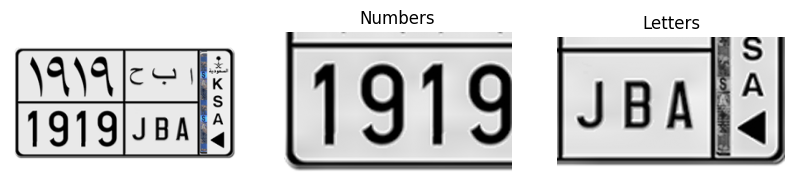

In [28]:
# Run the model on a sample image
image_filename = "/content/ckicvd7i3000l246adt7wcwlh.png"

try:
    print(f"⏳ Processing {image_filename}...")
    final_json, full_img, crop_L, crop_R = process_plate_clean(image_filename)

    print("\n--- ✅ FINAL JSON OUTPUT ---")
    print(json.dumps(final_json, indent=4, ensure_ascii=False))

    if full_img is not None:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(crop_L, cmap='gray'); plt.title("Numbers"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(crop_R, cmap='gray'); plt.title("Letters"); plt.axis('off')
        plt.show()

except Exception as e:
    print(f"Error: {e}")

> # Author: Hassan Alzourei